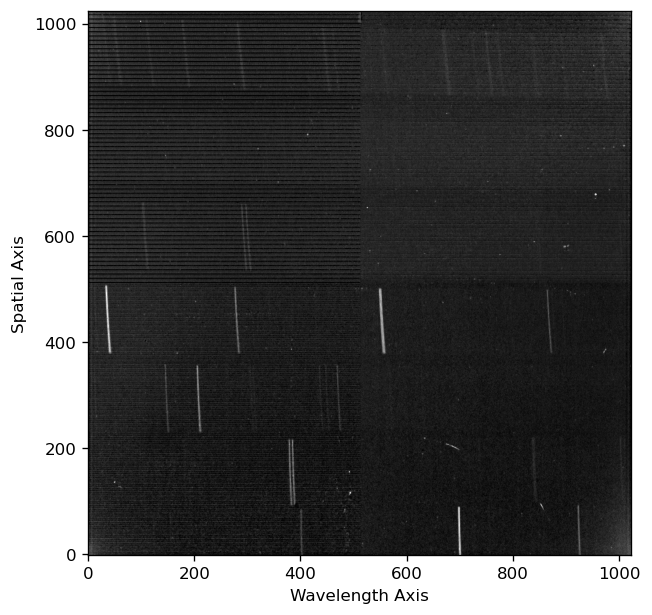

In [5]:
# import packages
from matplotlib import rcParams
rcParams['figure.dpi'] = 120
rcParams["savefig.dpi"] = 200
rcParams['figure.facecolor'] = 'w'

from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from lmfit import Model
from lmfit import minimize, Parameters

import os
import warnings
warnings.filterwarnings('ignore')

# path joining version for other paths
notebook_path = os.path.abspath('h3p.ipynb')
filepath = os.path.join(os.path.dirname(notebook_path), '02jun17/spec/')

# count number of fits files in folder
filesize = len([name for name in os.listdir(filepath) if os.path.isfile(os.path.join(filepath, name))])

# load fits data
nirspec7_data = []

start_nirspec7 = 22 # fits index start, min >= 1, max <= n
end_nirspec7 = 112 # fits index end, min >= n, max <= 999

# order36
for i in range(filesize):
    n = i + start_nirspec7
    if n>= start_nirspec7 and n < 10:
        hdu_data = fits.getdata(filepath + 'order36/test/' + 'jun02s000' + '{}_order36.fits'.format(n), ext=0)
        nirspec7_data.append(hdu_data)
    elif n>= 10 and n < 100:
        hdu_data = fits.getdata(filepath + 'order36/test/' + 'jun02s00' + '{}_order36.fits'.format(n), ext=0)
        nirspec7_data.append(hdu_data)
    elif n >= 100 and n < end_nirspec7: # fits index ends at 111
        hdu_data = fits.getdata(filepath + 'order36/test/' + 'jun02s0' + '{}_order36.fits'.format(n), ext=0)
        nirspec7_data.append(hdu_data)
    elif n >= end_nirspec7:
        break
nirspec7_data_array = np.array(nirspec7_data)

# load waverange
waverange = fits.open(filepath + 'order36/' + 'waverange.fits', ignore_missing_end=True)[0].data

# obtain average flat field
average_flat_field = np.mean((nirspec7_data_array[32-start_nirspec7], 
                              nirspec7_data_array[33-start_nirspec7], 
                              nirspec7_data_array[34-start_nirspec7], 
                              nirspec7_data_array[35-start_nirspec7], 
                              nirspec7_data_array[36-start_nirspec7], 
                              nirspec7_data_array[37-start_nirspec7], 
                              nirspec7_data_array[38-start_nirspec7], 
                              nirspec7_data_array[39-start_nirspec7], 
                              nirspec7_data_array[40-start_nirspec7], 
                              nirspec7_data_array[41-start_nirspec7],), axis=0)


# obtain average flat lamp off
average_flat_lamp_off = np.mean((nirspec7_data_array[22-start_nirspec7], 
                                 nirspec7_data_array[23-start_nirspec7], 
                                 nirspec7_data_array[24-start_nirspec7],
                                 nirspec7_data_array[25-start_nirspec7], 
                                 nirspec7_data_array[26-start_nirspec7], 
                                 nirspec7_data_array[27-start_nirspec7], 
                                 nirspec7_data_array[28-start_nirspec7], 
                                 nirspec7_data_array[29-start_nirspec7], 
                                 nirspec7_data_array[30-start_nirspec7], 
                                 nirspec7_data_array[31-start_nirspec7],), axis=0)

# convert observation time (UTC) to seconds 
def fits_header_utc_to_second(fn):
    # fn = frame_number
    if fn >= start_nirspec7 and fn < 10:
        hdu_header = fits.open(filepath + 'jun02s000' + '{}.fits'.format(fn), ignore_missing_end=True)[0].header
    elif fn >= 10 and fn < 100:
        hdu_header = fits.open(filepath + 'jun02s00' + '{}.fits'.format(fn), ignore_missing_end=True)[0].header
    elif fn >= 100 and fn < end_nirspec7:
        hdu_header = fits.open(filepath + 'jun02s0' + '{}.fits'.format(fn), ignore_missing_end=True)[0].header
    elif fn >= end_nirspec7:
        pass
    
    h = float(hdu_header['UTC'].split(':')[0])
    m = float(hdu_header['UTC'].split(':')[1])
    s = float(hdu_header['UTC'].split(':')[2])
    
    seconds = h * 3600 + m * 60 + s
    return seconds

# scale the sky frame using the equation on page 9 of Stallard_et_al_2019
def scale_sky_frame(fn_spec):
    """
    confirmed sky frames: 51, 59, 60, 72, 78, 79, 91, 103
    """
    if fn_spec > 51 and fn_spec < 59:
        fn_sky1 = 51 # frame number of sky1
        fn_sky2 = 59 # frame number of sky2
    elif fn_spec > 60 and fn_spec < 72:
        fn_sky1 = 60
        fn_sky2 = 72
    elif fn_spec > 72 and fn_spec < 78:
        fn_sky1 = 72
        fn_sky2 = 78
    elif fn_spec > 78 and fn_spec < 91:
        fn_sky1 = 79
        fn_sky2 = 91
    elif fn_spec > 91 and fn_spec < 103:
        fn_sky1 = 91
        fn_sky2 = 103

    sky1 = nirspec7_data_array[fn_sky1-start_nirspec7]
    sky2 = nirspec7_data_array[fn_sky2-start_nirspec7]

    t1 = fits_header_utc_to_second(fn_sky1) 
    t2 = fits_header_utc_to_second(fn_sky2)
    td = fits_header_utc_to_second(fn_spec)

    sky_final = sky1 * ((t2 - td) / (t2 - t1)) + sky2 * ((td - t1) / (t2 - t1))
    return sky_final

fn_spec = 65 # frame number of target spectra
sky_total = scale_sky_frame(fn_spec)

# remove sky background: (object - sky_frame)/(average_flat_field - average_flat_lamp_off)
sky_subtracted = (nirspec7_data_array[fn_spec-start_nirspec7] - sky_total) / (average_flat_field - average_flat_lamp_off)
#sky_subtracted[sky_subtracted>0.2] = 0.2
pixel = np.linspace(0, np.size(sky_subtracted, 1), np.size(sky_subtracted, 1))

# show reduced fits
#plt.figure(figsize=(12,6))
#plt.imshow(sky_subtracted, cmap='gist_gray')
#plt.xlabel('Wavelength Axis')
#plt.ylabel('Spatial Axis')
#plt.gca().invert_yaxis()
#plt.xlim(50,150)
#plt.ylim(40,130)
#plt.colorbar(orientation='horizontal', pad=0.1)


# define normalization function
def normalize(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

# define guassian function, credit to pen and pants IDL's Gaussfit in Python
def gaussian_fit(x, a0, a1, a2, a3, a4, a5): 
    """
    x = data array
    a0 = height of guassian
    a1 = pixel position of Gaussian peak
    a2 = width of Gaussian
    a3 = constant term
    a4 = linear term
    a5 = quadratic term
    
    note: fwhm = a2 * np.sqrt(2 * np.log(2)) * 2
    """
    z = (x - a1) / a2
    y = a0 * np.exp(-z**2 / a2) + a3 + a4 * x + a5 * x**2
    return y

# load skylines
skylines = fits.open(filepath + 'skyandarc2.fits', ignore_missing_end=True)[0].data

plt.figure(figsize=(12,6))
plt.imshow(skylines, cmap='gist_gray')
plt.xlabel('Wavelength Axis')
plt.ylabel('Spatial Axis')
plt.gca().invert_yaxis()

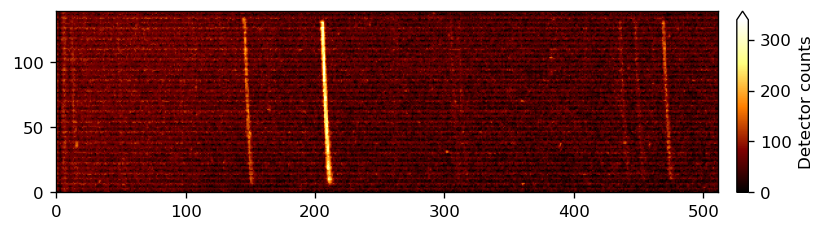

In [6]:
a = np.delete(skylines, np.s_[512:], 1)
b = np.delete(a, np.s_[:225], 0)
c = np.delete(b, np.s_[140:], 0)
#pixel = np.linspace(0, np.size(c, 1), np.size(c, 1))
plt.figure(figsize=(10,2))
plt.imshow(c, cmap='afmhot')
#plt.xlabel(r'Wavelength ($\mu$m)')
#plt.ylabel('Spatial Axis \nRow Position (0.432$^{\prime\prime}$ per pixel)')
#plt.title('a) Skylines measured by NIRSPEC')
plt.gca().invert_yaxis()
plt.colorbar(extend='max', aspect=15, pad=0.02, label='Detector counts')
#plt.xlim(140,155)

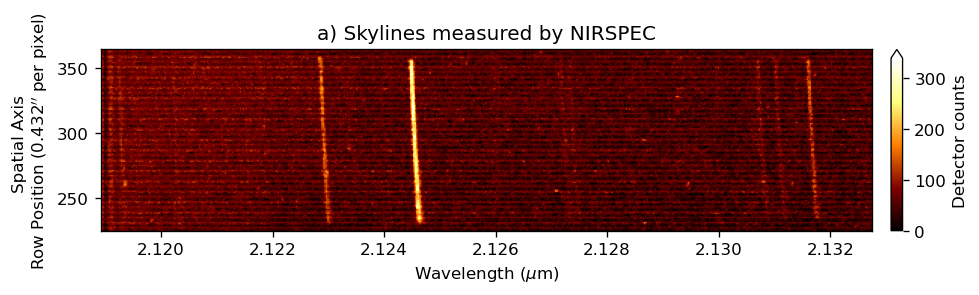

In [8]:
a = np.delete(skylines, np.s_[512:], 1)
b = np.delete(a, np.s_[:225], 0)
c = np.delete(b, np.s_[140:], 0)
#pixel = np.linspace(0, np.size(c, 1), np.size(c, 1))
plt.figure(figsize=(10,2))
plt.imshow(c, aspect='auto', extent=[waverange[0], waverange[511], 364, 225], cmap='afmhot')
plt.xlabel(r'Wavelength ($\mu$m)')
plt.ylabel('Spatial Axis \nRow Position (0.432$^{\prime\prime}$ per pixel)')
plt.title('a) Skylines measured by NIRSPEC')
plt.gca().invert_yaxis()
plt.colorbar(extend='max', aspect=15, pad=0.02, label='Detector counts')
#plt.savefig('poster/skyline_img', bbox_inches='tight', dpi=1000)

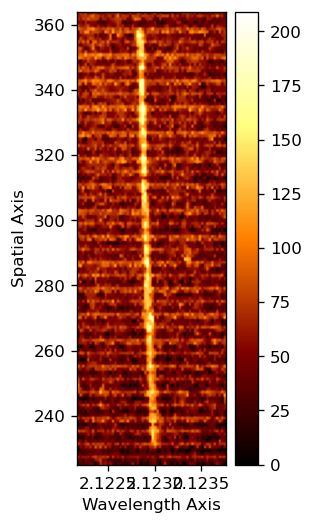

In [10]:
d = np.delete(c, np.s_[180:], 1)
e = np.delete(d, np.s_[:120], 1)
pixel = np.linspace(0, np.size(e, 1), np.size(e, 1))
plt.figure(figsize=(2,5))
plt.imshow(e, aspect='auto', extent=[waverange[120], waverange[179], 364, 225], cmap='afmhot')
plt.xlabel('Wavelength Axis')
plt.ylabel('Spatial Axis')
plt.gca().invert_yaxis()
#plt.ylim(225,235)
plt.colorbar()

In [135]:
d = np.delete(c, np.s_[180:], 1)
e = np.delete(d, np.s_[:120], 1)
#e[e<90] = 0
e = normalize(e)
#pixel = np.linspace(0, np.size(e, 1), np.size(e, 1))
pixel = waverange[120:180]*100000

upper_skyline = 135
lower_skyline = 10

sky1_a1 = np.zeros(upper_skyline - lower_skyline)

for i in range(lower_skyline, upper_skyline):
    if i >= 105 and i < upper_skyline:
        # create lmfit model with defined gaussian
        sky1_model = Model(gaussian_fit)

        # create parameters and add initial guess
        sky1_params = sky1_model.make_params()
        sky1_params.add('a0', value=1, min=0.5)
        sky1_params.add('a1', value=212286)
        sky1_params.add('a2', value=1)
        sky1_params.add('a3', value=0.3)
        sky1_params.add('a4', value=0)
        sky1_params.add('a5', value=0)
    
        try:
            sky1_fit_result = sky1_model.fit(e[i], sky1_params, x=pixel)
        except:
            print('Error occured at i=' + str(i))
            #print(sky1_fit_result.fit_report())
            plt.figure()
            plt.title('i='+str(i))
            plt.plot(pixel, e[i])
            plt.plot(pixel, sky1_fit_result.best_fit, 'r-', label='best fit')
            
        sky1_a1[i-lower_skyline] = sky1_fit_result.params['a1'].value
        
    if i >= 85 and i < 105:
        # create lmfit model with defined gaussian
        sky1_model = Model(gaussian_fit)

        # create parameters and add initial guess
        sky1_params = sky1_model.make_params()
        sky1_params.add('a0', value=1, min=0.5)
        sky1_params.add('a1', value=212288)
        sky1_params.add('a2', value=1)
        sky1_params.add('a3', value=0.3)
        sky1_params.add('a4', value=0)
        sky1_params.add('a5', value=0)
    
        try:
            sky1_fit_result = sky1_model.fit(e[i], sky1_params, x=pixel)
        except:
            print('Error occured at i=' + str(i))
            #print(sky1_fit_result.fit_report())
            plt.figure()
            plt.title('i='+str(i))
            plt.plot(pixel, e[i])
            plt.plot(pixel, sky1_fit_result.best_fit, 'r-', label='best fit')
            
        sky1_a1[i-lower_skyline] = sky1_fit_result.params['a1'].value
            
    if i >= 47 and i < 85:
        # create lmfit model with defined gaussian
        sky1_model = Model(gaussian_fit)

        # create parameters and add initial guess
        sky1_params = sky1_model.make_params()
        sky1_params.add('a0', value=1, min=0.5)
        sky1_params.add('a1', value=212292)
        sky1_params.add('a2', value=2)
        sky1_params.add('a3', value=0.3)
        sky1_params.add('a4', value=0)
        sky1_params.add('a5', value=0)
    
        try:
            sky1_fit_result = sky1_model.fit(e[i], sky1_params, x=pixel)
        except:
            print('Error occured at i=' + str(i))
            #print(sky1_fit_result.fit_report())
            plt.figure()
            plt.title('i='+str(i))
            plt.plot(pixel, e[i])
            plt.plot(pixel, sky1_fit_result.best_fit, 'r-', label='best fit')
            
        sky1_a1[i-lower_skyline] = sky1_fit_result.params['a1'].value
        
    if i >= 30 and i < 47:
        # create lmfit model with defined gaussian
        sky1_model = Model(gaussian_fit)

        # create parameters and add initial guess
        sky1_params = sky1_model.make_params()
        sky1_params.add('a0', value=0.7, min=0.5)
        sky1_params.add('a1', value=212295)
        sky1_params.add('a2', value=2)
        sky1_params.add('a3', value=0.3)
        sky1_params.add('a4', value=0)
        sky1_params.add('a5', value=0)
    
        try:
            sky1_fit_result = sky1_model.fit(e[i], sky1_params, x=pixel)
        except:
            print('Error occured at i=' + str(i))
            print(sky1_fit_result.fit_report())
            plt.figure()
            plt.title('i='+str(i))
            plt.plot(pixel, e[i])
            plt.plot(pixel, sky1_fit_result.best_fit, 'r-', label='best fit')
            
        sky1_a1[i-lower_skyline] = sky1_fit_result.params['a1'].value
            
    if i >= 10 and i < 30:
        # create lmfit model with defined gaussian
        sky1_model = Model(gaussian_fit)

        # create parameters and add initial guess
        sky1_params = sky1_model.make_params()
        sky1_params.add('a0', value=0.7)
        sky1_params.add('a1', value=212300)
        sky1_params.add('a2', value=2)
        sky1_params.add('a3', value=0.3)
        sky1_params.add('a4', value=0)
        sky1_params.add('a5', value=0)
    
        try:
            sky1_fit_result = sky1_model.fit(e[i], sky1_params, x=pixel)
        except:
            print('Error occured at i=' + str(i))
            #print(sky1_fit_result.fit_report())
            plt.figure()
            plt.title('i='+str(i))
            plt.plot(pixel, e[i])
            plt.plot(pixel, sky1_fit_result.best_fit, 'r-', label='best fit')
            
        sky1_a1[i-lower_skyline] = sky1_fit_result.params['a1'].value
sky1_a1 = sky1_a1/100000

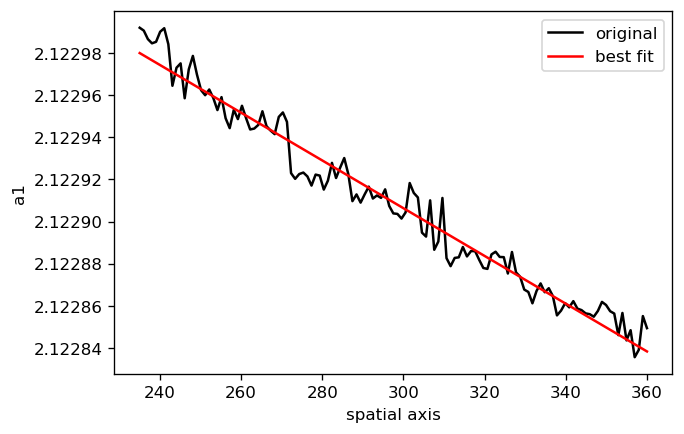

In [193]:
sky1_spat = np.linspace(0, len(sky1_a1), len(sky1_a1))+225+10

def residual(params, x, data):
    k = params['k']
    b = params['b']

    model = k * x + b

    return (data-model)


params = Parameters()
params.add('k', value=-0.05)
params.add('b', value=212300)

out = minimize(residual, params, args=(sky1_spat, sky1_a1))

sky1_k = out.params['k'].value
sky1_b = out.params['b'].value


plt.figure()
plt.plot(sky1_spat, sky1_a1,'k', label = 'original')
plt.plot(sky1_spat, sky1_k*sky1_spat + sky1_b, 'r', label = 'best fit')
plt.xlabel('spatial axis')
plt.ylabel('a1')
plt.ticklabel_format(useOffset=False)
plt.legend()

In [137]:
sky1_a1_offset = sky1_a1 - 2.1232420081711174
sky1_a1_offset

array([-0.00024998, -0.00025134, -0.00025537, -0.00025738, -0.00025667,
       -0.00025188, -0.0002502 , -0.00025779, -0.00027753, -0.00026896,
       -0.0002669 , -0.00028346, -0.00026973, -0.00026336, -0.00027224,
       -0.0002796 , -0.00028201, -0.0002793 , -0.00028337, -0.00028908,
       -0.00028293, -0.00029295, -0.00029765, -0.00028897, -0.00029336,
       -0.00028703, -0.00029287, -0.00029829, -0.00029785, -0.0002961 ,
       -0.00028964, -0.00029671, -0.00029883, -0.00030051, -0.00029232,
       -0.0002902 , -0.00029467, -0.00031903, -0.00032172, -0.00031945,
       -0.00031874, -0.00032059, -0.00032493, -0.00031972, -0.00032019,
       -0.00032684, -0.00032262, -0.00031415, -0.00032133, -0.00031641,
       -0.00031185, -0.00031954, -0.00033233, -0.00032913, -0.00033302,
       -0.00032908, -0.00032543, -0.00033108, -0.00032961, -0.00033078,
       -0.00032671, -0.00033462, -0.00033814, -0.00033838, -0.00034059,
       -0.00033765, -0.00032372, -0.00032843, -0.00033057, -0.00

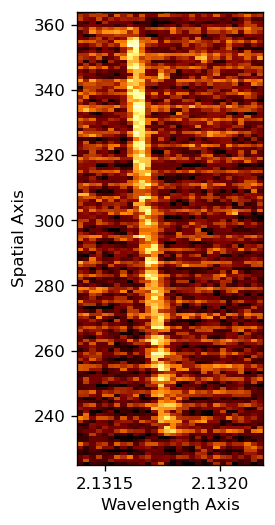

In [160]:
f = np.delete(c, np.s_[490:], 1)
g = np.delete(f, np.s_[:460], 1)
pixel = np.linspace(0, np.size(g, 1), np.size(g, 1))
plt.figure(figsize=(2,5))
plt.imshow(g, aspect='auto', extent=[waverange[460], waverange[490], 364, 225], cmap='afmhot')
plt.xlabel('Wavelength Axis')
plt.ylabel('Spatial Axis')
plt.ticklabel_format(useOffset=False)
plt.gca().invert_yaxis()
#plt.ylim(225,245)

In [189]:
f = np.delete(c, np.s_[490:], 1)
g = np.delete(f, np.s_[:460], 1)
#pixel = np.linspace(0, np.size(g, 1), np.size(g, 1))
pixel = waverange[460:490]*100000

upper_skyline = 135
lower_skyline = 10

sky3_a1 = np.zeros(upper_skyline - lower_skyline)

for i in range(lower_skyline, upper_skyline):
    if i >= 105 and i < upper_skyline:
        # create lmfit model with defined gaussian
        sky3_model = Model(gaussian_fit)

        # create parameters and add initial guess
        sky3_params = sky3_model.make_params()
        sky3_params.add('a0', value=1)
        sky3_params.add('a1', value=213160)
        sky3_params.add('a2', value=2)
        sky3_params.add('a3', value=0.3)
        sky3_params.add('a4', value=0)
        sky3_params.add('a5', value=0)
    
        try:
            sky3_fit_result = sky3_model.fit(normalize(g[i]), sky3_params, x=pixel)
        except:
            print('Error occured at i=' + str(i))
            #print(sky3_fit_result.fit_report())
            plt.figure()
            plt.title('i='+str(i))
            plt.plot(pixel, normalize(g[i]))
            plt.plot(pixel, sky3_fit_result.best_fit, 'r-', label='best fit')
            
        sky3_a1[i-lower_skyline] = sky3_fit_result.params['a1'].value
            
    if i >= 75 and i < 105:
        # create lmfit model with defined gaussian
        sky3_model = Model(gaussian_fit)

        # create parameters and add initial guess
        sky3_params = sky3_model.make_params()
        sky3_params.add('a0', value=1)
        sky3_params.add('a1', value=213165)
        sky3_params.add('a2', value=2)
        sky3_params.add('a3', value=0.3)
        sky3_params.add('a4', value=0)
        sky3_params.add('a5', value=0)
    
        try:
            sky3_fit_result = sky3_model.fit(normalize(g[i]), sky3_params, x=pixel)
        except:
            print('Error occured at i=' + str(i))
            #print(sky3_fit_result.fit_report())
            plt.figure()
            plt.title('i='+str(i))
            plt.plot(pixel, normalize(g[i]))
            plt.plot(pixel, sky3_fit_result.best_fit, 'r-', label='best fit')
            
        sky3_a1[i-lower_skyline] = sky3_fit_result.params['a1'].value
        
    if i >= 45 and i < 75:
        # create lmfit model with defined gaussian
        sky3_model = Model(gaussian_fit)

        # create parameters and add initial guess
        sky3_params = sky3_model.make_params()
        sky3_params.add('a0', value=1)
        sky3_params.add('a1', value=213170)
        sky3_params.add('a2', value=1)
        sky3_params.add('a3', value=0.3)
        sky3_params.add('a4', value=0)
        sky3_params.add('a5', value=0)
    
        try:
            sky3_fit_result = sky3_model.fit(normalize(g[i]), sky3_params, x=pixel)
        except:
            print('Error occured at i=' + str(i))
            #print(sky3_fit_result.fit_report())
            plt.figure()
            plt.title('i='+str(i))
            plt.plot(pixel, normalize(g[i]))
            plt.plot(pixel, sky3_fit_result.best_fit, 'r-', label='best fit')
            
        sky3_a1[i-lower_skyline] = sky3_fit_result.params['a1'].value
        
    if i >= 30 and i < 45:
        # create lmfit model with defined gaussian
        sky3_model = Model(gaussian_fit)

        # create parameters and add initial guess
        sky3_params = sky3_model.make_params()
        sky3_params.add('a0', value=1)
        sky3_params.add('a1', value=213170)
        sky3_params.add('a2', value=2)
        sky3_params.add('a3', value=0.3)
        sky3_params.add('a4', value=0)
        sky3_params.add('a5', value=0)
    
        try:
            sky3_fit_result = sky3_model.fit(normalize(g[i]), sky3_params, x=pixel)
        except:
            print('Error occured at i=' + str(i))
            #print(sky3_fit_result.fit_report())
            plt.figure()
            plt.title('i='+str(i))
            plt.plot(pixel, normalize(g[i]))
            plt.plot(pixel, sky3_fit_result.best_fit, 'r-', label='best fit')
        
        sky3_a1[i-lower_skyline] = sky3_fit_result.params['a1'].value
            
    if i >= 10 and i < 30:
        # create lmfit model with defined gaussian
        sky3_model = Model(gaussian_fit)

        # create parameters and add initial guess
        sky3_params = sky3_model.make_params()
        sky3_params.add('a0', value=1)
        sky3_params.add('a1', value=213175)
        sky3_params.add('a2', value=3)
        sky3_params.add('a3', value=0.2)
        sky3_params.add('a4', value=0)
        sky3_params.add('a5', value=0)
    
        try:
            sky3_fit_result = sky3_model.fit(normalize(g[i]), sky3_params, x=pixel)
        except:
            print('Error occured at i=' + str(i))
            #print(sky3_fit_result.fit_report())
            plt.figure()
            plt.title('i='+str(i))
            plt.plot(pixel, normalize(g[i]))
            plt.plot(pixel, sky3_fit_result.best_fit, 'r-', label='best fit')
        
        sky3_a1[i-lower_skyline] = sky3_fit_result.params['a1'].value
        
sky3_a1 = sky3_a1/100000

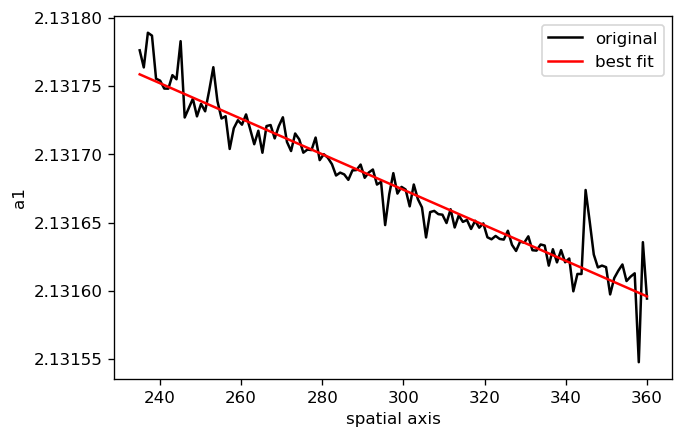

In [198]:
sky3_spat = np.linspace(0, len(sky3_a1), len(sky3_a1))+225+10

def residual(params, x, data):
    k = params['k']
    b = params['b']

    model = k * x + b

    return (data-model)


params = Parameters()
params.add('k', value=-0.05)
params.add('b', value=2.1317)

out = minimize(residual, params, args=(sky3_spat, sky3_a1))

sky3_k = out.params['k'].value
sky3_b = out.params['b'].value


plt.figure()
plt.plot(sky3_spat, sky3_a1,'k', label = 'original')
plt.plot(sky3_spat, sky3_k*sky3_spat + sky3_b, 'r', label = 'best fit')
plt.xlabel('spatial axis')
plt.ylabel('a1')
plt.ticklabel_format(useOffset=False)
plt.legend()

In [229]:
sky3_a1_offset = sky3_a1 - 2.1325969957673254
sky3_a1_offset

array([-0.00082085, -0.00083338, -0.00080798, -0.0008101 , -0.00084165,
       -0.00084308, -0.00084886, -0.00084895, -0.00083906, -0.00084206,
       -0.00081417, -0.00087006, -0.00086318, -0.00085634, -0.00086922,
       -0.00086008, -0.00086554, -0.00085014, -0.00083322, -0.00085806,
       -0.00087078, -0.00086912, -0.00089311, -0.00087795, -0.00087207,
       -0.00087533, -0.0008678 , -0.00087858, -0.00088962, -0.00087977,
       -0.00089588, -0.00087634, -0.00087558, -0.00088539, -0.00087641,
       -0.00086989, -0.00088797, -0.00089463, -0.00088178, -0.00088608,
       -0.00089583, -0.00089357, -0.00089393, -0.00088477, -0.00090129,
       -0.00089693, -0.0008996 , -0.00090432, -0.00091254, -0.00091044,
       -0.00091175, -0.00091573, -0.00090882, -0.00090854, -0.00090454,
       -0.00091422, -0.00091036, -0.00090816, -0.00091919, -0.00091723,
       -0.00094886, -0.00092633, -0.00091083, -0.0009258 , -0.00092089,
       -0.00092279, -0.00093514, -0.00091915, -0.00092986, -0.00

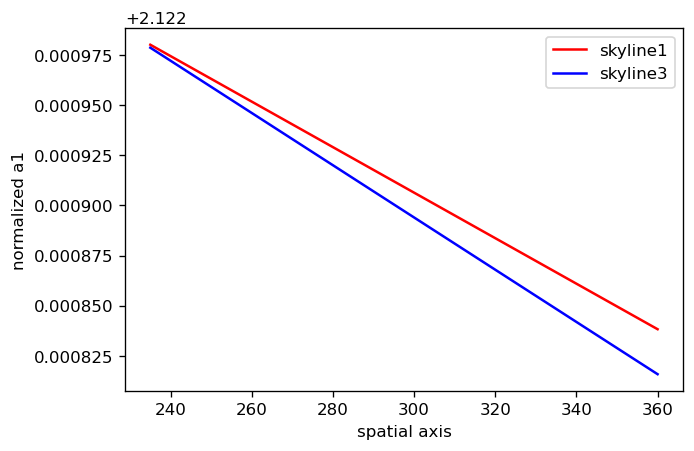

In [227]:
plt.figure()
plt.plot(sky1_spat, sky1_k*sky1_spat + sky1_b, 'r', label = 'skyline1')
plt.plot(sky3_spat, sky3_k*sky3_spat + sky3_b-0.00878, 'b', label = 'skyline3')
plt.xlabel('spatial axis')
plt.ylabel('normalized a1')
plt.legend()

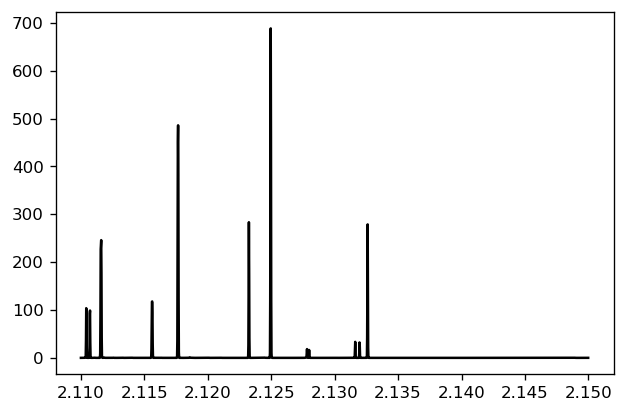

In [77]:
gemini_df = pd.read_csv('mk_skybg_zm_10_10_ph.dat', sep='\s+', header=None)
gemini_array = gemini_df.to_numpy()

wavelength = (gemini_array[60500:62500,0]/1000)#[gemini_array[60500:62500,1]>0.5]
count = gemini_array[60500:62500,1]#[gemini_array[60500:62500,1]>0.5]

plt.plot(wavelength, count, 'k')
#plt.xlim(min(wavelength), max(wavelength))
#plt.xlim(2.11,2.15)
#plt.xlim(2.132,2.133)
#plt.ylim(min(count), 800)

[[Model]]
    Model(gaussian_fit)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 110
    # data points      = 2000
    # variables        = 6
    chi-square         = 1191667.40
    reduced chi-square = 597.626579
    Akaike info crit   = 12791.9232
    Bayesian info crit = 12825.5286
[[Variables]]
    a0:  692.744456 +/- 21.6923162 (3.13%) (init = 692)
    a1:  2.12496000 +/- 7.7693e-07 (0.00%) (init = 2.125)
    a2:  9.7318e-04 +/- 2.3439e-05 (2.41%) (init = 0.004)
    a3:  36579.6693 +/- 20819.4136 (56.92%) (init = 0)
    a4: -34121.4975 +/- 19549.2942 (57.29%) (init = 0)
    a5:  7957.19951 +/- 4589.05680 (57.67%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(a4, a5) = -1.000
    C(a3, a4) = -1.000
    C(a3, a5) =  1.000
    C(a0, a2) = -0.574


2.124959996615822

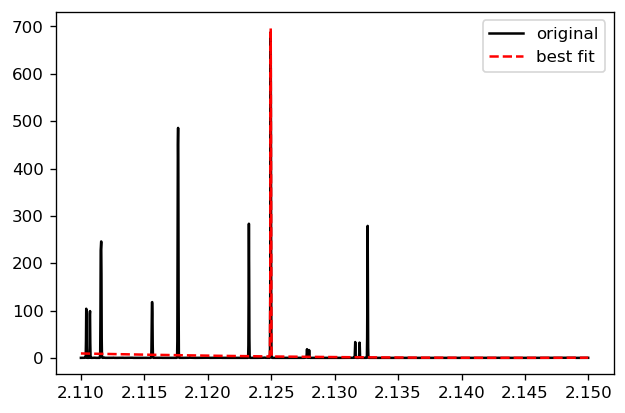

In [61]:
# create lmfit model with defined gaussian
g1_model = Model(gaussian_fit)
#print('parameter names: {}'.format(g1model.param_names))
#print('independent variables: {}'.format(g1model.independent_vars))


# create parameters and add initial guess
g1_params = g1_model.make_params()
g1_params.add('a0', value=692)
g1_params.add('a1', value=2.125)
g1_params.add('a2', value=0.004)
g1_params.add('a3', value=0)
g1_params.add('a4', value=0)
g1_params.add('a5', value=0)

try:
    g1_result = g1_model.fit(count, g1_params, x=wavelength)
except:
    pass

print(g1_result.fit_report())

plt.figure()
plt.plot(wavelength, count, 'k', label='original')
plt.plot(wavelength, g1_result.best_fit, 'r--', label='best fit')
plt.legend()
#plt.xlim(2.1246,2.1252)

g1_result.params['a1'].value

[[Model]]
    Model(gaussian_fit)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 50
    # data points      = 2000
    # variables        = 6
    chi-square         = 1968234.92
    reduced chi-square = 987.078697
    Akaike info crit   = 13795.4905
    Bayesian info crit = 13829.0959
[[Variables]]
    a0:  281.745623 +/- 29.5132383 (10.48%) (init = 290)
    a1:  2.12324201 +/- 2.3124e-06 (0.00%) (init = 2.12325)
    a2:  8.9566e-04 +/- 7.1761e-05 (8.01%) (init = 0.003)
    a3:  13890.0431 +/- 26743.6554 (192.54%) (init = 0)
    a4: -12797.1761 +/- 25112.1148 (196.23%) (init = 0)
    a5:  2947.18976 +/- 5894.88832 (200.02%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(a4, a5) = -1.000
    C(a3, a4) = -1.000
    C(a3, a5) =  1.000
    C(a0, a2) = -0.569


2.1232420081711174

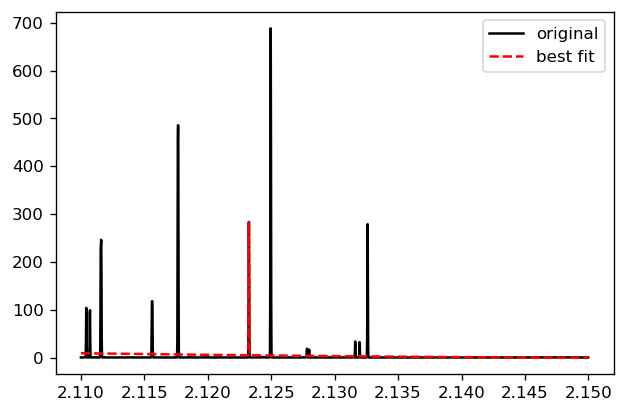

In [62]:
# create lmfit model with defined gaussian
g2_model = Model(gaussian_fit)

# create parameters and add initial guess
g2_params = g2_model.make_params()
g2_params.add('a0', value=290)
g2_params.add('a1', value=2.12325)
g2_params.add('a2', value=0.003)
g2_params.add('a3', value=0)
g2_params.add('a4', value=0)
g2_params.add('a5', value=0)

try:
    g2_result = g2_model.fit(count, g2_params, x=wavelength)
except:
    pass

print(g2_result.fit_report())

plt.figure()
plt.plot(wavelength, count, 'k', label='original')
plt.plot(wavelength, g2_result.best_fit, 'r--', label='best fit')
plt.legend()
#plt.xlim(2.123,2.1235)

g2_result.params['a1'].value

[[Model]]
    Model(gaussian_fit)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 43
    # data points      = 2000
    # variables        = 6
    chi-square         = 1970173.72
    reduced chi-square = 988.051013
    Akaike info crit   = 13797.4596
    Bayesian info crit = 13831.0651
[[Variables]]
    a0:  280.903097 +/- 29.6742776 (10.56%) (init = 290)
    a1:  2.13259700 +/- 2.3132e-06 (0.00%) (init = 2.1326)
    a2:  8.9078e-04 +/- 7.2196e-05 (8.10%) (init = 0.003)
    a3:  17929.9224 +/- 26776.3484 (149.34%) (init = 0)
    a4: -16567.2074 +/- 25142.7126 (151.76%) (init = 0)
    a5:  3826.68314 +/- 5902.04709 (154.23%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(a4, a5) = -1.000
    C(a3, a4) = -1.000
    C(a3, a5) =  1.000
    C(a0, a2) = -0.570


2.1325969957673254

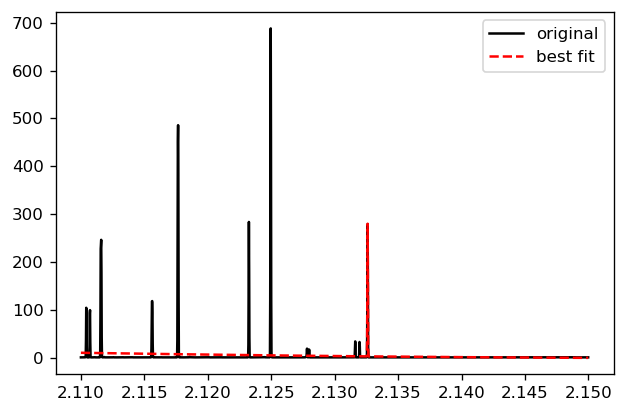

In [64]:
# create lmfit model with defined gaussian
g3_model = Model(gaussian_fit)

# create parameters and add initial guess
g3_params = g3_model.make_params()
g3_params.add('a0', value=290)
g3_params.add('a1', value=2.1326)
g3_params.add('a2', value=0.003)
g3_params.add('a3', value=0)
g3_params.add('a4', value=0)
g3_params.add('a5', value=0)

try:
    g3_result = g3_model.fit(count, g3_params, x=wavelength)
except:
    pass

print(g3_result.fit_report())

plt.figure()
plt.plot(wavelength, count, 'k', label='original')
plt.plot(wavelength, g3_result.best_fit, 'r--', label='best fit')
plt.legend()
#plt.xlim(2.132,2.133)

g3_result.params['a1'].value

d = np.delete(c, np.s_[180:], 1)
e = np.delete(d, np.s_[:120], 1)
pixel = np.linspace(0, np.size(e, 1), np.size(e, 1))
#pixel = waverange[120:180]

upper_skyline = 135
lower_skyline = 10

sky1_a1 = np.zeros(upper_skyline - lower_skyline)

for i in range(lower_skyline, upper_skyline):
    if i >= 105 and i < upper_skyline:
        # create lmfit model with defined gaussian
        sky1_model = Model(gaussian_fit)

        # create parameters and add initial guess
        sky1_params = sky1_model.make_params()
        sky1_params.add('a0', value=1)
        sky1_params.add('a1', value=26)
        sky1_params.add('a2', value=1)
        sky1_params.add('a3', value=0.3)
        sky1_params.add('a4', value=0)
        sky1_params.add('a5', value=0)
    
        try:
            sky1_fit_result = sky1_model.fit(normalize(e[i]), sky1_params, x=pixel)
        except:
            print('Error occured at i=' + str(i))
            #print(sky1_fit_result.fit_report())
            plt.figure()
            plt.title('i='+str(i))
            plt.plot(pixel, normalize(e[i]))
            plt.plot(pixel, sky1_fit_result.best_fit, 'r-', label='best fit')
            
        sky1_a1[i-lower_skyline] = sky1_fit_result.params['a1'].value
            
    if i >= 45 and i < 105:
        # create lmfit model with defined gaussian
        sky1_model = Model(gaussian_fit)

        # create parameters and add initial guess
        sky1_params = sky1_model.make_params()
        sky1_params.add('a0', value=1)
        sky1_params.add('a1', value=28)
        sky1_params.add('a2', value=1)
        sky1_params.add('a3', value=0.3)
        sky1_params.add('a4', value=0)
        sky1_params.add('a5', value=0)
    
        try:
            sky1_fit_result = sky1_model.fit(normalize(e[i]), sky1_params, x=pixel)
        except:
            print('Error occured at i=' + str(i))
            #print(sky1_fit_result.fit_report())
            plt.figure()
            plt.title('i='+str(i))
            plt.plot(pixel, normalize(e[i]))
            plt.plot(pixel, sky1_fit_result.best_fit, 'r-', label='best fit')
            
        sky1_a1[i-lower_skyline] = sky1_fit_result.params['a1'].value
            
    if i >= 5 and i < 45:
        # create lmfit model with defined gaussian
        sky1_model = Model(gaussian_fit)

        # create parameters and add initial guess
        sky1_params = sky1_model.make_params()
        sky1_params.add('a0', value=1)
        sky1_params.add('a1', value=30)
        sky1_params.add('a2', value=1)
        sky1_params.add('a3', value=0.3)
        sky1_params.add('a4', value=0)
        sky1_params.add('a5', value=0)
    
        try:
            sky1_fit_result = sky1_model.fit(normalize(e[i]), sky1_params, x=pixel)
        except:
            print('Error occured at i=' + str(i))
            print(sky1_fit_result.fit_report())
            plt.figure()
            plt.title('i='+str(i))
            plt.plot(pixel, normalize(e[i]))
            plt.plot(pixel, sky1_fit_result.best_fit, 'r-', label='best fit')
        
        sky1_a1[i-lower_skyline] = sky1_fit_result.params['a1'].value
sky1_a1 = sky1_a1 + 120


sky1_spat = np.linspace(0, len(sky1_a1), len(sky1_a1))+225+10

def residual(params, x, data):
    k = params['k']
    b = params['b']

    model = k * x + b

    return (data-model)


params = Parameters()
params.add('k', value=-0.05)
params.add('b', value=150)

out = minimize(residual, params, args=(sky1_spat, sky1_a1))

sky1_k = out.params['k'].value
sky1_b = out.params['b'].value


plt.figure()
plt.plot(sky1_spat, sky1_a1,'k', label = 'original')
plt.plot(sky1_spat, sky1_k*sky1_spat + sky1_b, 'r', label = 'best fit')
plt.xlabel('spatial axis')
plt.ylabel('a1')
#plt.annotate('k='+str(round(out.params['k'].value, 7)), xy=(0, 0.4))
#plt.annotate('b='+str(round(out.params['b'].value, 7)), xy=(0, 0.35))
plt.legend()

f = np.delete(c, np.s_[490:], 1)
g = np.delete(f, np.s_[:460], 1)
pixel = np.linspace(0, np.size(g, 1), np.size(g, 1))

upper_skyline = 135
lower_skyline = 10

sky3_a1 = np.zeros(upper_skyline - lower_skyline)

for i in range(lower_skyline, upper_skyline):
    if i >= 105 and i < upper_skyline:
        # create lmfit model with defined gaussian
        sky3_model = Model(gaussian_fit)

        # create parameters and add initial guess
        sky3_params = sky3_model.make_params()
        sky3_params.add('a0', value=1)
        sky3_params.add('a1', value=9)
        sky3_params.add('a2', value=1)
        sky3_params.add('a3', value=0.3)
        sky3_params.add('a4', value=0)
        sky3_params.add('a5', value=0)
    
        try:
            sky3_fit_result = sky3_model.fit(normalize(g[i]), sky3_params, x=pixel)
        except:
            print('Error occured at i=' + str(i))
            #print(sky3_fit_result.fit_report())
            plt.figure()
            plt.title('i='+str(i))
            plt.plot(pixel, normalize(g[i]))
            plt.plot(pixel, sky3_fit_result.best_fit, 'r-', label='best fit')
            
        sky3_a1[i-lower_skyline] = sky3_fit_result.params['a1'].value
            
    if i >= 75 and i < 105:
        # create lmfit model with defined gaussian
        sky3_model = Model(gaussian_fit)

        # create parameters and add initial guess
        sky3_params = sky3_model.make_params()
        sky3_params.add('a0', value=1)
        sky3_params.add('a1', value=11)
        sky3_params.add('a2', value=1)
        sky3_params.add('a3', value=0.3)
        sky3_params.add('a4', value=0)
        sky3_params.add('a5', value=0)
    
        try:
            sky3_fit_result = sky3_model.fit(normalize(g[i]), sky3_params, x=pixel)
        except:
            print('Error occured at i=' + str(i))
            #print(sky3_fit_result.fit_report())
            plt.figure()
            plt.title('i='+str(i))
            plt.plot(pixel, normalize(g[i]))
            plt.plot(pixel, sky3_fit_result.best_fit, 'r-', label='best fit')
            
        sky3_a1[i-lower_skyline] = sky3_fit_result.params['a1'].value
        
    if i >= 45 and i < 75:
        # create lmfit model with defined gaussian
        sky3_model = Model(gaussian_fit)

        # create parameters and add initial guess
        sky3_params = sky3_model.make_params()
        sky3_params.add('a0', value=1)
        sky3_params.add('a1', value=12)
        sky3_params.add('a2', value=1)
        sky3_params.add('a3', value=0.3)
        sky3_params.add('a4', value=0)
        sky3_params.add('a5', value=0)
    
        try:
            sky3_fit_result = sky3_model.fit(normalize(g[i]), sky3_params, x=pixel)
        except:
            print('Error occured at i=' + str(i))
            #print(sky3_fit_result.fit_report())
            plt.figure()
            plt.title('i='+str(i))
            plt.plot(pixel, normalize(g[i]))
            plt.plot(pixel, sky3_fit_result.best_fit, 'r-', label='best fit')
            
        sky3_a1[i-lower_skyline] = sky3_fit_result.params['a1'].value
            
    if i >= 10 and i < 45:
        # create lmfit model with defined gaussian
        sky3_model = Model(gaussian_fit)

        # create parameters and add initial guess
        sky3_params = sky3_model.make_params()
        sky3_params.add('a0', value=1)
        sky3_params.add('a1', value=14)
        sky3_params.add('a2', value=1)
        sky3_params.add('a3', value=0.3)
        sky3_params.add('a4', value=0)
        sky3_params.add('a5', value=0)
    
        try:
            sky3_fit_result = sky3_model.fit(normalize(g[i]), sky3_params, x=pixel)
        except:
            print('Error occured at i=' + str(i))
            #print(sky3_fit_result.fit_report())
            plt.figure()
            plt.title('i='+str(i))
            plt.plot(pixel, normalize(g[i]))
            plt.plot(pixel, sky3_fit_result.best_fit, 'r-', label='best fit')
        
        sky3_a1[i-lower_skyline] = sky3_fit_result.params['a1'].value
        
sky3_a1 = sky3_a1 + 460


sky3_spat = np.linspace(0, len(sky3_a1), len(sky3_a1))

def residual(params, x, data):
    k = params['k']
    b = params['b']

    model = k * x + b

    return (data-model)


params = Parameters()
params.add('k', value=-0.05)
params.add('b', value=1)

out = minimize(residual, params, args=(sky3_spat, normalize(sky3_a1)))

sky3_k = out.params['k'].value
sky3_b = out.params['b'].value


plt.figure()
plt.plot(sky3_spat, normalize(sky3_a1),'k', label = 'original')
plt.plot(sky3_spat, sky3_k*sky3_spat + sky3_b, 'r', label = 'best fit')
plt.xlabel('spatial axis')
plt.ylabel('a1')
plt.annotate('k='+str(round(out.params['k'].value, 7)), xy=(0, 0.4))
plt.annotate('b='+str(round(out.params['b'].value, 7)), xy=(0, 0.35))
plt.legend()